In [1]:
import pandas as pd
from swifter import swifter
import re
import gc
pd.set_option('display.max_columns', 100)  
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from string import digits
import gensim
import seaborn as sns
from sklearn import preprocessing
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
from sklearn.model_selection import train_test_split
%pylab inline

/opt/anaconda3/lib/python3.6/site-packages/fastparquet/dataframe.py:7: FutureWarning: 'pandas.core' is private. Use 'pandas.Categorical'
  from pandas.core.categorical import Categorical, CategoricalDtype


Populating the interactive namespace from numpy and matplotlib


### Checking GPU

In [ ]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

### LSTM

In [48]:
from keras.initializers import glorot_normal, orthogonal

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/opt/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [49]:
from keras.layers import Input,Lambda, CuDNNLSTM
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Activation, Dropout, SpatialDropout1D, Flatten, Reshape, Bidirectional, BatchNormalization
from keras.layers.convolutional import Conv1D
from keras import initializers, regularizers, constraints, optimizers, layers


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras
from keras.utils import np_utils
import keras.backend as K

In [50]:
from os import environ
from collections import Counter
environ["CUDA_VISIBLE_DEVICES"]="0,1"

### SIAM LOGIT MODEL LSTM with attention

In [63]:
from keras.engine.topology import Layer
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [64]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score

def aucroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [65]:
vocab_size=min(len(tokenizer_word.word_index),vocab_sz)

In [66]:
# The visible layer
left_input = Input(
                    shape=(max_seq_len,),# dtype='int32'
                  )
right_input = Input(
                    shape=(max_seq_len,), #dtype='int32'
                   )

embedding_layer = Embedding(vocab_size+1,
                            weights=[embedding_matrix],
                            embedding_size, 
                            input_length=max_seq_len, 
                            trainable=True #False if you prefer train own emb.
                           ) 

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_left = SpatialDropout1D(0.1)(encoded_left)

encoded_right = embedding_layer(right_input)
encoded_right = SpatialDropout1D(0.1)(encoded_right)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = CuDNNLSTM(64)#LSTM(64)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

merged=concatenate([left_output, right_output], axis=1)
dense=Dense(512, activation='relu')(merged)
dense = BatchNormalization()(dense)
predictions=Dense(1, activation='sigmoid')(dense)

# Pack it all up into a model
loglstm = Model([left_input, right_input], [predictions])

In [67]:
batch_size=128
n_epoch=8


loglstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', f1])

# Start training
#training_start_time = time()

history  = loglstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, epochs=n_epoch, verbose=1,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation))

Train on 592371 samples, validate on 65820 samples
Epoch 1/8
592371/592371 [==============================] - 306s 516us/step - loss: 0.1796 - acc: 0.9171 - f1: 0.3003 - val_loss: 0.1433 - val_acc: 0.9211 - val_f1: 0.3695
Epoch 2/8
592371/592371 [==============================] - 305s 515us/step - loss: 0.1361 - acc: 0.9224 - f1: 0.4459 - val_loss: 0.1312 - val_acc: 0.9241 - val_f1: 0.5307
Epoch 3/8
592371/592371 [==============================] - 317s 535us/step - loss: 0.1238 - acc: 0.9255 - f1: 0.4917 - val_loss: 0.1220 - val_acc: 0.9257 - val_f1: 0.4982
Epoch 4/8
592371/592371 [==============================] - 318s 537us/step - loss: 0.1180 - acc: 0.9266 - f1: 0.5132 - val_loss: 0.1187 - val_acc: 0.9263 - val_f1: 0.4284
Epoch 5/8
592371/592371 [==============================] - 318s 537us/step - loss: 0.1139 - acc: 0.9279 - f1: 0.5287 - val_loss: 0.1156 - val_acc: 0.9252 - val_f1: 0.6295
Epoch 6/8
592371/592371 [==============================] - 318s 536us/step - loss: 0.1113 - ac

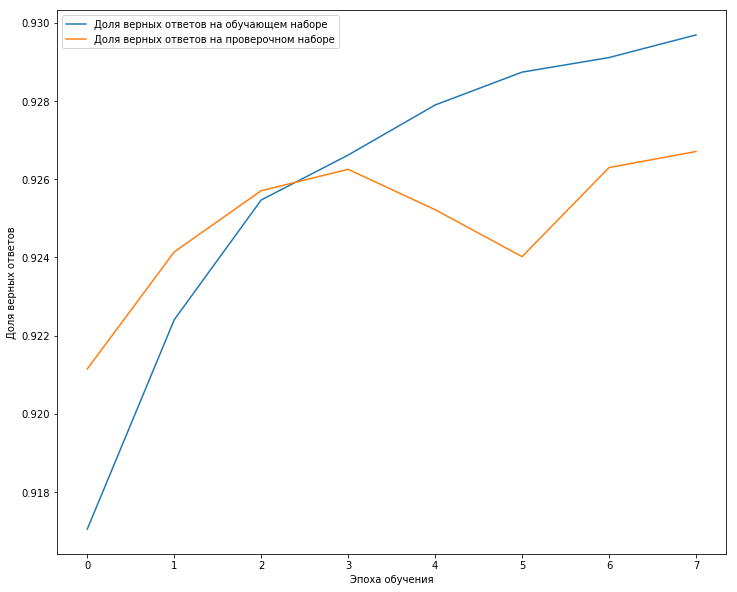

In [68]:
plt.figure(figsize=(12,10))
plt.plot(history.history['acc'], label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_acc'], label='Доля верных ответов на проверочном наборе')
#plt.plot(history.history['aucroc'], label='auc')
#plt.plot(history.history['val_aucroc'], label='val_auc')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

### Save/Load Model siames example

In [85]:
from keras.models import load_model

In [86]:
loglstm.save('siames_model_cudnn_dnpp_cutoff_02.h5')  # creates a HDF5 file 'my_model.h5'

In [121]:
model = load_model('siames_model_cudnn_dnpp_cutoff_02.h5', compile=False)

In [122]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', f1])

In [96]:
del(loglstm)
gc.collect()

14825